Importation du modèle VCC-16


In [1]:
import os
%cd
from keras.applications.vgg16 import VGG16

model = VGG16( include_top=True,
              weights='imagenet',
              input_tensor=None,
              input_shape=None,
              pooling=None,
              classes=1000,
              classifier_activation='softmax'
             ) # Création du modèle VGG-16 implementé par Keras


/home/fedecabre


/home/fedecabre


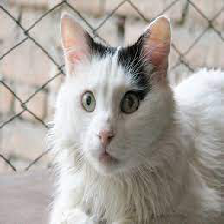

In [2]:
%cd
# à la racine pour avoir accès aux datas
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

project_path ='Documents/OC_Ingenieur_ML/P6_Classez_des_images/'
img = load_img(project_path+'data/cat.jpeg', target_size=(224, 224))  # Charger l'image
display(img)
img = img_to_array(img)  # Convertir en tableau numpy
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
y = model.predict(img)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

In [5]:
from keras.applications.vgg16 import decode_predictions

# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions(y, top=3)[0])

Top 3 : [('n02124075', 'Egyptian_cat', 0.25156984), ('n02127052', 'lynx', 0.19743551), ('n01877812', 'wallaby', 0.16383485)]


# Transfert Learning


Features (train_data.mat, test_data.mat):
 - train_data/test_data
   -- contains the feature matrix after histogram intersection kernel has been applied
 - train_fg_data/test_fg_data
   -- contains the feature matrix before applying the histogram intersection kernel
 - train_info/test_info
   -- contains the labels and ids for the corresponding image in the feature matrix

In [6]:
import os
import numpy as np
import imageio
from xml.dom import minidom
from PIL import Image

def make_dataset_race(folder,image_size=224, num_channels = 3):
    image_files=os.listdir(project_path+folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size,num_channels), dtype=np.float32)
    num_images = 0
    for image in image_files:
        image_file = project_path+folder+'/'+image
        image_data = imageio.imread(image_file)
        if image_data.shape[2]==num_channels: # on prend que les images avec 3 channels
            annon_file = project_path+'data/Annotation' + '/' + folder.split('/')[-1] + '/' + image.split('.')[0]
            annon_xml = minidom.parse(annon_file)
            xmin = int(annon_xml.getElementsByTagName('xmin')[0].firstChild.nodeValue)
            ymin = int(annon_xml.getElementsByTagName('ymin')[0].firstChild.nodeValue)
            xmax = int(annon_xml.getElementsByTagName('xmax')[0].firstChild.nodeValue)
            ymax = int(annon_xml.getElementsByTagName('ymax')[0].firstChild.nodeValue)
            new_image_data = image_data[ymin:ymax,xmin:xmax,:]

            #bounding carré rempli de noir
            x = xmax-xmin
            y = ymax-ymin
            if x<y:
                squarre_image = np.zeros((y,y,num_channels))
                delta = ((y-x)//2)
                squarre_image[:new_image_data.shape[0],delta:(new_image_data.shape[1])+delta,:] = new_image_data
                squarre_image = squarre_image.astype(np.uint8)
            if x>y:
                squarre_image = np.zeros((x,x,num_channels))
                delta = ((x-y)//2)
                squarre_image[delta:(new_image_data.shape[0]+delta),:new_image_data.shape[1],:] = new_image_data
                squarre_image = squarre_image.astype(np.uint8)

            new_image = Image.fromarray(squarre_image)
            new_image = new_image.resize(size=(image_size,image_size),)
            crop_dir = project_path+'data/Cropped/'+ folder.split('/')[-1]
            if os.path.exists(project_path+'data/Cropped/') is False:
                os.mkdir(project_path+'data/Cropped/')
            if os.path.exists(crop_dir) is False:
                os.mkdir(crop_dir)
            #new_image.save(crop_dir+'/'+image)
            dataset[num_images, :, :, :] = np.array(new_image)
            num_images = num_images + 1
    dataset = dataset[0:num_images, :, :, :]
    print('Full dataset tensor:', dataset.shape)
    return dataset

folder = 'data/Images/n02085620-Chihuahua'
dataset_chien = make_dataset_race(folder)

Full dataset tensor: (152, 224, 224, 3)


In [7]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.zeros((nb_rows,img_size, img_size,num_channels), dtype=np.float32)
        labels = np.zeros((nb_rows,), dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

In [8]:
images_folders_path = "data/Images/"
images_folders=os.listdir(project_path+images_folders_path)

num_classes = 10 #len(images_folders)
train_size  = 1000
valid_size  = 500
image_size  = 224
num_channels= 3

# Création des datasets vides
valid_dataset, valid_labels = make_arrays(valid_size, image_size)
train_dataset, train_labels = make_arrays(train_size, image_size)


vsize_per_class = valid_size // num_classes # il peut être NULL
tsize_per_class = train_size // num_classes

start_v, start_t = 0, 0
end_v, end_t = vsize_per_class, tsize_per_class
end_l = vsize_per_class+tsize_per_class

# make a dictionary
dog_race_dict = dict()

for label,folder in enumerate(images_folders):
    if label < num_classes :
        print(str(label+1)+'/'+str(num_classes)+' - '+folder.split('-')[-1])
        dog_race_dict[folder.split('-')[-1]] = label
        dataset_race = make_dataset_race('data/Images/'+folder)
        train_breed = dataset_race[vsize_per_class:end_l, :, :, :]
        train_dataset[start_t:end_t, :, :, :] = train_breed
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
        if valid_dataset is not None:
            valid_breed = dataset_race[:vsize_per_class, :, :, :]
            valid_dataset[start_v:end_v, :, :, :] = valid_breed
            valid_labels[start_v:end_v] = label
            start_v += vsize_per_class
            end_v += vsize_per_class

dog_race_invert_dict = {v: k for k, v in dog_race_dict.items()}

1/10 - Bedlington_terrier
Full dataset tensor: (182, 224, 224, 3)
2/10 - collie
Full dataset tensor: (153, 224, 224, 3)
3/10 - Greater_Swiss_Mountain_dog
Full dataset tensor: (168, 224, 224, 3)
4/10 - bull_mastiff
Full dataset tensor: (156, 224, 224, 3)
5/10 - flat_coated_retriever
Full dataset tensor: (152, 224, 224, 3)
6/10 - Leonberg
Full dataset tensor: (210, 224, 224, 3)
7/10 - affenpinscher
Full dataset tensor: (150, 224, 224, 3)
8/10 - English_foxhound
Full dataset tensor: (157, 224, 224, 3)
9/10 - kuvasz
Full dataset tensor: (150, 224, 224, 3)
10/10 - tan_coonhound
Full dataset tensor: (159, 224, 224, 3)


In [9]:
dog_race_dict

{'Bedlington_terrier': 0,
 'collie': 1,
 'Greater_Swiss_Mountain_dog': 2,
 'bull_mastiff': 3,
 'flat_coated_retriever': 4,
 'Leonberg': 5,
 'affenpinscher': 6,
 'English_foxhound': 7,
 'kuvasz': 8,
 'tan_coonhound': 9}

In [10]:
print(train_dataset.shape)
print(train_labels.shape)
print(valid_dataset.shape)
print(valid_labels.shape)

(1000, 224, 224, 3)
(1000,)
(500, 224, 224, 3)
(500,)


In [12]:
values, counts = np.unique(train_labels, return_counts=True)
values

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [13]:
counts

array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100])

In [14]:
num_classes

10

In [15]:
len(images_folders)

120

In [16]:
#train_labels_one_hot = np.zeros((train_labels.size, train_labels.max()+1))
#train_labels_one_hot[np.arange((train_labels.size),train_labels)]=1
#train_labels_one_hot.shape

from keras.utils.np_utils import to_categorical

train_labels_categorical = to_categorical(train_labels, num_classes=num_classes)
valid_labels_categorical = to_categorical(valid_labels, num_classes=num_classes)
print(train_labels_categorical.shape)
print(valid_labels_categorical.shape)

(1000, 10)
(500, 10)


# Modèle VCC-16

## Fonction métriques

In [17]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [68]:
def min_loss_max_acc(model_info):
    loss_min = min(model_info.history['val_loss'])
    loss_min_epoch = model_info.history['val_loss'].index(loss_min)+1
    acc_max = max(model_info.history['val_accuracy'])
    acc_max_epoch = model_info.history['val_accuracy'].index(acc_max)+1
    return np.round(loss_min,decimals=5), loss_min_epoch, np.round(acc_max,decimals=5), acc_max_epoch

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
def clas_report(model,valid_dataset,valid_labels):
    # Classification Report
    Y_pred = model.predict(valid_dataset)
    valid_labels_pred = np.argmax(Y_pred, axis=1)
    print('Classification Report')
    target_names = ['Cats', 'Dogs', 'Horse']
    print(classification_report(valid_labels, valid_labels_pred, target_names=dog_race_dict.keys()))

In [20]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
def conf_matr(model,valid_dataset,valid_labels):
    Y_pred = model.predict(valid_dataset)
    valid_labels_pred = np.argmax(Y_pred, axis=1)
    array = confusion_matrix(valid_labels, valid_labels_pred)
    df_cm = pd.DataFrame(array, index = [i for i in dog_race_dict.keys()],
                      columns = [i for i in dog_race_dict.keys()])
    plt.figure(figsize = (15,13)).patch.set_facecolor('w')
    sn.heatmap(df_cm, annot=True)

In [43]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve,auc,roc_auc_score

def multiclass_roc_auc_score(model,valid_dataset, valid_labels, labels, average="macro"):
    Y_pred = model.predict(valid_dataset)
    valid_labels_pred = np.argmax(Y_pred, axis=1)
    fig, c_ax = plt.subplots(1,1, figsize = (12, 8),)
    fig.patch.set_facecolor('w')
    lb = LabelBinarizer()
    lb.fit(valid_labels)
    y_test = lb.transform(valid_labels)
    y_pred = lb.transform(valid_labels_pred)

    for (idx, c_label) in enumerate(labels): # all_labels: no of the labels, for ex. ['cat', 'dog', 'rat']
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()
    return roc_auc_score(y_test, y_pred, average=average)

## Fonctions d'affichage

In [24]:
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(project_path, "Graphs")
os.makedirs(IMAGES_PATH, exist_ok=True)

IMAGES_PATH = project_path + "Graphs/"

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [25]:
import matplotlib.pyplot as plt

def plot_loss(model_info,graph_name,loss_min,tight_layout=True, fig_extension="png", resolution=300):
    loss = model_info.history['loss']
    val_loss = model_info.history['val_loss']

    epochs = range(1, len(loss) + 1)
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('w')
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss '+ graph_name+'\n'
              "num_classes = " + str(num_classes) +
              ", train_size = " + str(train_size) + 
              ", valid_size = " + str(valid_size) + '\n'
              "image_size = " + str(image_size) +
              ", num_channels = " + str(num_channels))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.axvline(x=loss_min,color='red',linestyle='--')
    fig_id=(graph_name + ' training_and_validation_accuracy'+ 
              "-num_classes=" + str(num_classes) +
              "-train_size=" + str(train_size) + 
              "-valid_size=" + str(valid_size) + 
              "-image_size=" + str(image_size) +
              "-num_channels=" + str(num_channels))
    save_fig(fig_id, tight_layout, fig_extension, resolution)
    plt.show()
    

In [26]:
plt.clf()   # clear figure

def plot_accuracy(model_info,graph_name,acc_max,tight_layout=True, fig_extension="png", resolution=300):
    acc_train = model_info.history['accuracy']
    acc_val = model_info.history['val_accuracy']
    
    epochs = range(1, len(acc_train) + 1)
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('w')
    plt.plot(epochs, acc_train, 'bo', label='Training accuracy')
    plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy '+ graph_name+'\n'
              "num_classes = " + str(num_classes) +
              ", train_size = " + str(train_size) + 
              ", valid_size = " + str(valid_size) + '\n'
              "image_size = " + str(image_size) +
              ", num_channels = " + str(num_channels))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.axvline(x=acc_max,color='red',linestyle='--')
    fig_id=(graph_name + ' training_and_validation_accuracy'+ 
              "-num_classes=" + str(num_classes) +
              "-train_size=" + str(train_size) + 
              "-valid_size=" + str(valid_size) + 
              "-image_size=" + str(image_size) +
              "-num_channels=" + str(num_channels))
    save_fig(fig_id, tight_layout, fig_extension, resolution)
    plt.show()
    

<Figure size 432x288 with 0 Axes>

## Stratégie fine tunning partiel

### modèle

In [71]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Récupérer la sortie de ce réseau
x = model.output

# Ajouter la nouvelle couche fully-connected pour la classification à 10 classes
F = Flatten()(x)
DL1 = Dense(30)(F)
DL2 = Dense(30)(DL1)
predictions = Dense(num_classes, activation='softmax')(DL2)

# Stratégie #2 : extraction de features
for layer in model.layers:
    layer.trainable = False

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)


Entraînement du modèle


In [72]:
# Compiler le modèle
new_model.compile(loss="categorical_crossentropy",
                  optimizer='adam',
                  metrics=["accuracy",f1_m,precision_m,recall_m])

new_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Entraînement

In [73]:
# Entraîner sur les données d'entraînement (X_train, y_train)
model1_info = new_model.fit(train_dataset,
                           train_labels_categorical,
                           epochs=15,
                           batch_size=32,
                           #verbose=2,
                           validation_data=(valid_dataset,valid_labels_categorical)
                           )

Epoch 1/15
32/32 [==============================] - 11s 337ms/step - loss: 31.1458 - accuracy: 0.6000 - f1_m: 0.6067 - precision_m: 0.6069 - recall_m: 0.6064 - val_loss: 13.2399 - val_accuracy: 0.7880 - val_f1_m: 0.7801 - val_precision_m: 0.7801 - val_recall_m: 0.7801
Epoch 2/15
32/32 [==============================] - 10s 330ms/step - loss: 2.8684 - accuracy: 0.9440 - f1_m: 0.9453 - precision_m: 0.9453 - recall_m: 0.9453 - val_loss: 7.1996 - val_accuracy: 0.8720 - val_f1_m: 0.8738 - val_precision_m: 0.8738 - val_recall_m: 0.8738
Epoch 3/15
32/32 [==============================] - 11s 333ms/step - loss: 1.1312 - accuracy: 0.9730 - f1_m: 0.9736 - precision_m: 0.9736 - recall_m: 0.9736 - val_loss: 8.0226 - val_accuracy: 0.8720 - val_f1_m: 0.8680 - val_precision_m: 0.8680 - val_recall_m: 0.8680
Epoch 4/15
32/32 [==============================] - 11s 333ms/step - loss: 0.4274 - accuracy: 0.9880 - f1_m: 0.9883 - precision_m: 0.9883 - recall_m: 0.9883 - val_loss: 7.2903 - val_accuracy: 0.886

### Résultats

Saving figure model2 val_loss min=0.14466 training_and_validation_accuracy-num_classes=10-train_size=1000-valid_size=500-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

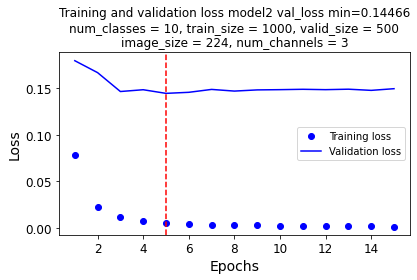

In [74]:
loss_min, loss_min_epoch, _, _ = min_loss_max_acc(model2_info)
plot_loss(model2_info,'model2 val_loss min='+str(loss_min),loss_min=loss_min_epoch)


Saving figure model2 val_acc_max=0.958 training_and_validation_accuracy-num_classes=10-train_size=1000-valid_size=500-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

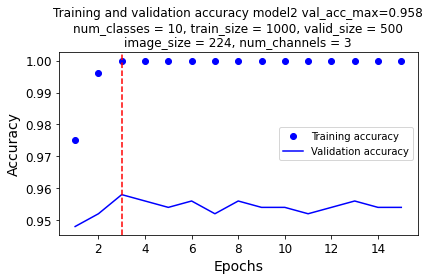

In [75]:
_, _, acc_max, acc_max_epoch = min_loss_max_acc(model2_info)
plot_accuracy(model2_info,'model2 val_acc_max='+str(acc_max),acc_max=acc_max_epoch)


In [76]:
clas_report(new_model,valid_dataset,valid_labels)

Classification Report
                            precision    recall  f1-score   support

        Bedlington_terrier       0.98      0.82      0.89        50
                    collie       0.82      0.90      0.86        50
Greater_Swiss_Mountain_dog       1.00      0.66      0.80        50
              bull_mastiff       0.98      0.88      0.93        50
     flat_coated_retriever       0.81      0.88      0.85        50
                  Leonberg       0.92      0.94      0.93        50
             affenpinscher       0.96      0.94      0.95        50
          English_foxhound       0.73      0.92      0.81        50
                    kuvasz       0.84      0.86      0.85        50
             tan_coonhound       0.82      0.94      0.88        50

                  accuracy                           0.87       500
                 macro avg       0.89      0.87      0.87       500
              weighted avg       0.89      0.87      0.87       500



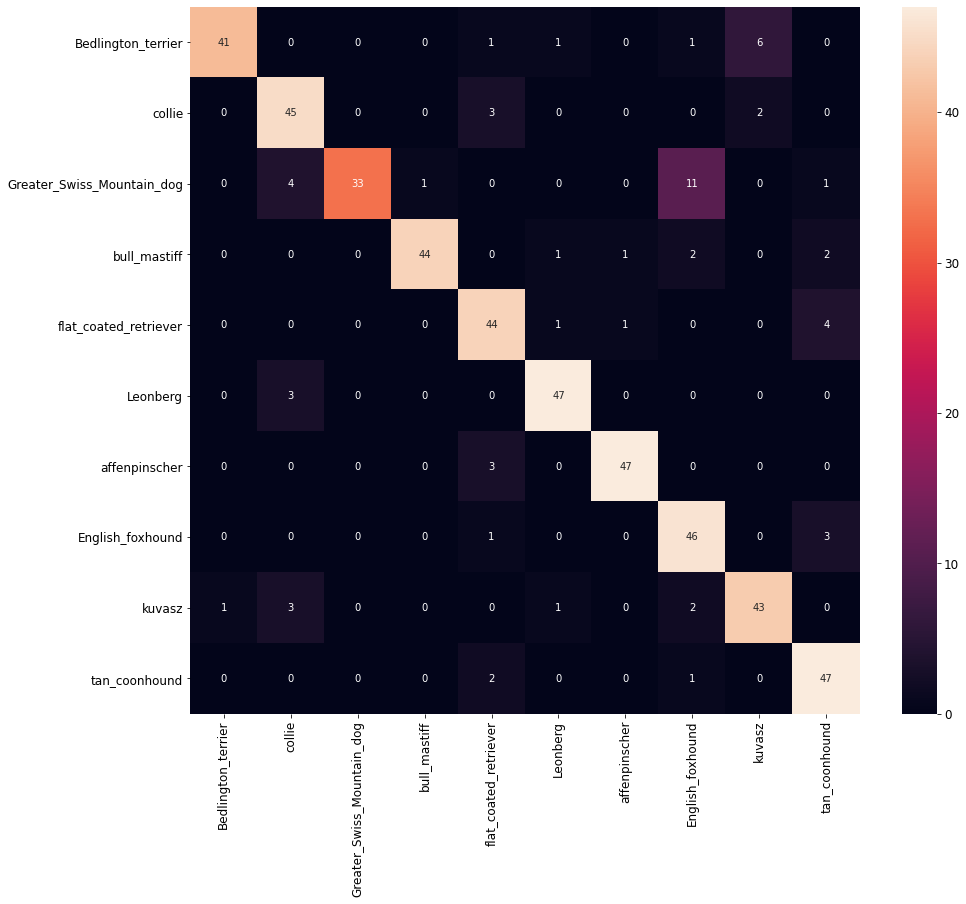

In [77]:
conf_matr(new_model,valid_dataset,valid_labels)

In [79]:


print('ROC AUC score:', multiclass_roc_auc_score(valid_labels, valid_labels_pred, dog_race_dict.keys()))

NameError: name 'valid_labels_pred' is not defined

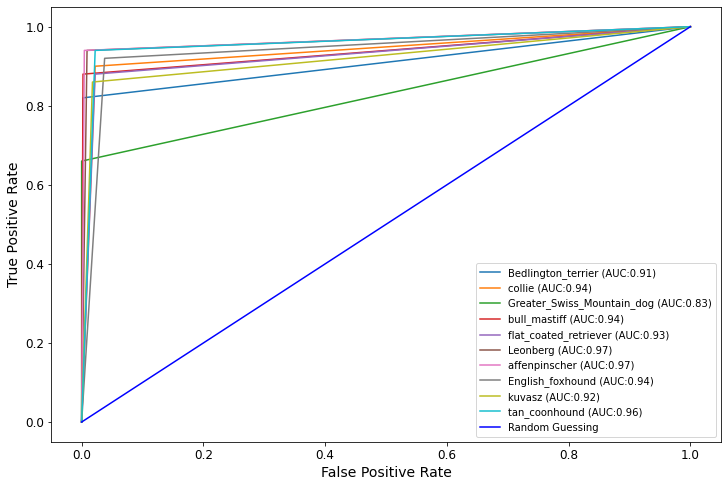

ROC AUC score: 0.93


In [81]:
print('ROC AUC score:',
multiclass_roc_auc_score(new_model,
                         valid_dataset,
                         valid_labels,
                         dog_race_dict.keys(),
                         average="macro")
     )

## Stratégie extraction des features (model 2)

### Modèle

In [36]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model,callbacks
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

# Récupérer la sortie de ce réseau
x = model.layers[-2].output

# Ajouter la nouvelle couche fully-connected pour la classification à 10 classes

predictions = Dense(num_classes, activation='softmax')(x)

# Stratégie #2 : extraction de features
for layer in model.layers[:-1]:
    layer.trainable = False

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)


In [37]:
# Compiler le modèle
new_model.compile(loss="categorical_crossentropy",
                  optimizer='adam',
                  metrics=["accuracy",f1_m,precision_m,recall_m])
new_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Entraînement

In [39]:
%time
# Entraîner sur les données d'entraînement (train_dataset, train_labels_categorical)
# Val_continue de décendre après 120 epochs
model2_info = new_model.fit(train_dataset,
                           train_labels_categorical,
                           epochs=15,
                           batch_size=32,
                           #verbose=2,
                           validation_data=(valid_dataset,valid_labels_categorical)
                           )

CPU times: user 13 µs, sys: 2 µs, total: 15 µs
Wall time: 26.5 µs
Epoch 1/15
32/32 [==============================] - 11s 344ms/step - loss: 0.0782 - accuracy: 0.9750 - f1_m: 0.9750 - precision_m: 0.9785 - recall_m: 0.9717 - val_loss: 0.1798 - val_accuracy: 0.9480 - val_f1_m: 0.9508 - val_precision_m: 0.9544 - val_recall_m: 0.9473
Epoch 2/15
32/32 [==============================] - 11s 336ms/step - loss: 0.0229 - accuracy: 0.9960 - f1_m: 0.9961 - precision_m: 0.9961 - recall_m: 0.9961 - val_loss: 0.1670 - val_accuracy: 0.9520 - val_f1_m: 0.9471 - val_precision_m: 0.9526 - val_recall_m: 0.9418
Epoch 3/15
32/32 [==============================] - 11s 337ms/step - loss: 0.0113 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.1466 - val_accuracy: 0.9580 - val_f1_m: 0.9555 - val_precision_m: 0.9584 - val_recall_m: 0.9527
Epoch 4/15
32/32 [==============================] - 11s 338ms/step - loss: 0.0070 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.

### Résultats

Saving figure model2 val_loss min=0.14466 training_and_validation_accuracy-num_classes=10-train_size=1000-valid_size=500-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

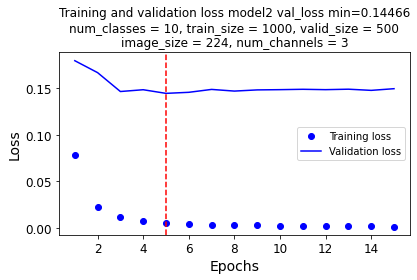

In [69]:
loss_min, loss_min_epoch, _, _ = min_loss_max_acc(model2_info)
plot_loss(model2_info,'model2 val_loss min='+str(loss_min),loss_min=loss_min_epoch)


Saving figure model2 val_acc_max=0.958 training_and_validation_accuracy-num_classes=10-train_size=1000-valid_size=500-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

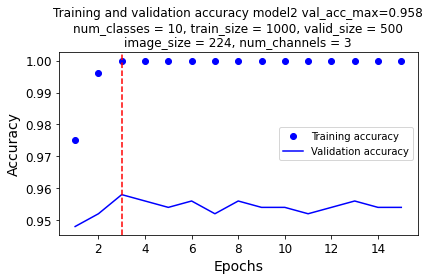

In [70]:
_, _, acc_max, acc_max_epoch = min_loss_max_acc(model2_info)
plot_accuracy(model2_info,'model2 val_acc_max='+str(acc_max),acc_max=acc_max_epoch)


In [41]:

clas_report(new_model,valid_dataset,valid_labels)

Classification Report
                            precision    recall  f1-score   support

        Bedlington_terrier       0.98      0.96      0.97        50
                    collie       0.98      1.00      0.99        50
Greater_Swiss_Mountain_dog       0.98      0.96      0.97        50
              bull_mastiff       0.94      0.94      0.94        50
     flat_coated_retriever       0.94      0.92      0.93        50
                  Leonberg       0.98      0.94      0.96        50
             affenpinscher       1.00      0.98      0.99        50
          English_foxhound       0.92      0.92      0.92        50
                    kuvasz       0.92      0.98      0.95        50
             tan_coonhound       0.90      0.94      0.92        50

                  accuracy                           0.95       500
                 macro avg       0.95      0.95      0.95       500
              weighted avg       0.95      0.95      0.95       500



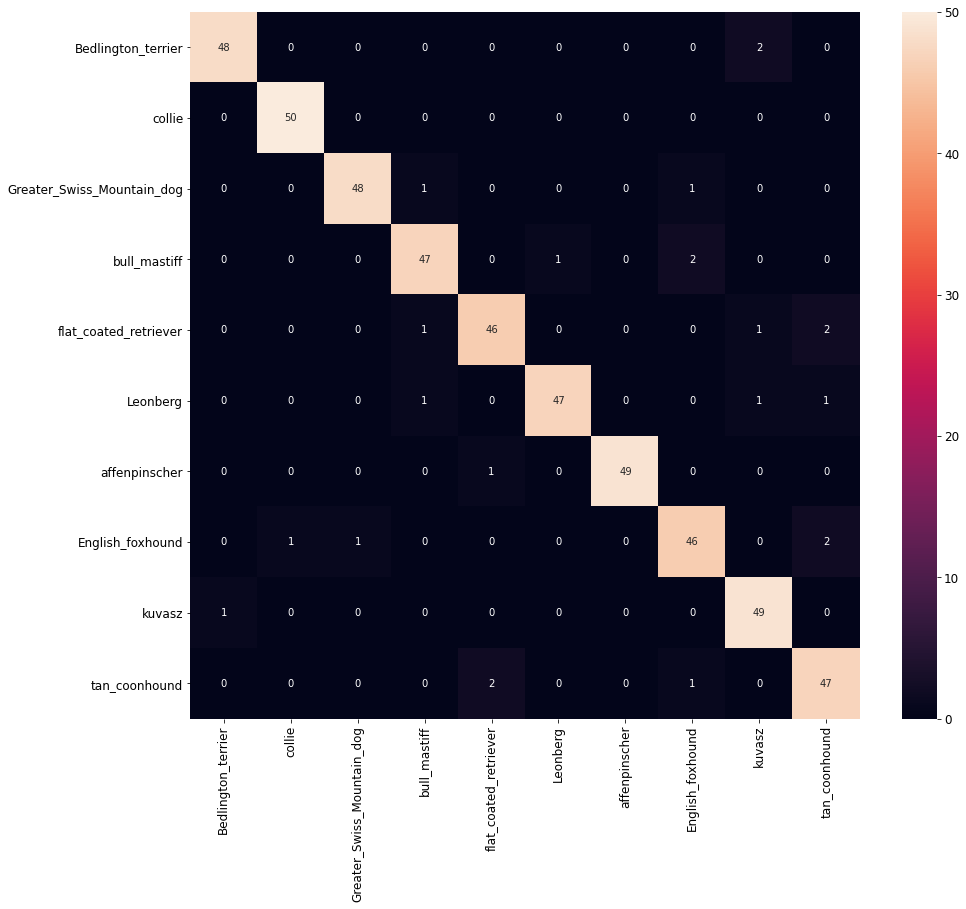

In [40]:
conf_matr(new_model,valid_dataset,valid_labels)

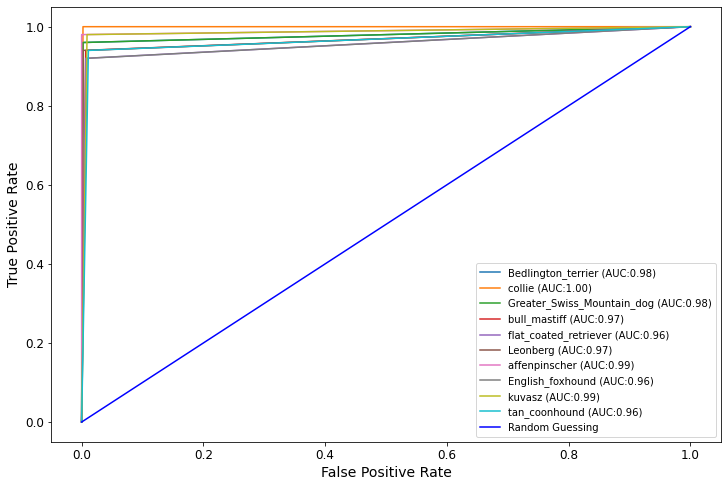

0.9744444444444443

In [47]:
print('ROC AUC score:',
multiclass_roc_auc_score(new_model,
                         valid_dataset,
                         valid_labels,
                         dog_race_dict.keys(),
                         average="macro")
     )